In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from collections import deque
import os
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pickle
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
import time

# Dataset

In [28]:
# Load the first dataset (needs to be in the same folder as ipynb)
hikari = pd.read_csv("ALLFLOWMETER_HIKARI2021.csv")
hikari.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], inplace=True)

In [29]:
# Load the second dataset (needs to be in the same folder as ipynb)
PATH_TO_CIC = "CIC-DDoS2019"
cic_paths = os.listdir(PATH_TO_CIC)
cic_train_paths = [os.path.join(PATH_TO_CIC, path) for path in cic_paths if "-training" in path]
cic_test_paths = [os.path.join(PATH_TO_CIC, path) for path in cic_paths if "-testing" in path]


train_prefixes = [path.split('/')[-1].split('-')[0] for path in cic_train_paths]
test_prefixes = [path.split('/')[-1].split('-')[0] for path in cic_test_paths]

common_prefixes = list(set(train_prefixes).intersection(test_prefixes))

cic_train_paths = [path for path in cic_train_paths if path.split('/')[-1].split('-')[0] in common_prefixes]
cic_test_paths = [path for path in cic_test_paths if path.split('/')[-1].split('-')[0] in common_prefixes]

cic_train = pd.concat([pd.read_parquet(path) for path in cic_train_paths], ignore_index=True)
cic_test = pd.concat([pd.read_parquet(path) for path in cic_test_paths], ignore_index=True)

In [30]:
# Convert key names from dataset 1 to dataset 2 
hikari_to_cic_keys = {
    'flow_duration': 'Flow Duration',
    'fwd_pkts_tot': 'Total Fwd Packets',
    'bwd_pkts_tot': 'Total Backward Packets',
    'fwd_data_pkts_tot': 'Fwd Packets Length Total',
    'bwd_data_pkts_tot': 'Bwd Packets Length Total',
    'fwd_pkts_per_sec': 'Fwd Packets/s',
    'bwd_pkts_per_sec': 'Bwd Packets/s',
    'down_up_ratio': 'Down/Up Ratio',
    'fwd_header_size_tot': 'Fwd Header Length',
    'bwd_header_size_tot': 'Bwd Header Length',
    'flow_pkts_per_sec': 'Flow Packets/s',
    'flow_iat.avg': 'Flow IAT Mean',
    'flow_iat.std': 'Flow IAT Std',
    'flow_iat.max': 'Flow IAT Max',
    'flow_iat.min': 'Flow IAT Min',
    'fwd_iat.tot': 'Fwd IAT Total', 
    'fwd_iat.max': 'Fwd IAT Max',
    'fwd_iat.avg': 'Fwd IAT Mean',
    'fwd_iat.std': 'Fwd IAT Std',
    'fwd_iat.min': 'Fwd IAT Min',
    'bwd_iat.tot': 'Bwd IAT Total',
    'bwd_iat.avg': 'Bwd IAT Mean',
    'bwd_iat.max': 'Bwd IAT Max',
    'bwd_iat.min': 'Bwd IAT Min',
    'bwd_iat.std': 'Bwd IAT Std',
    'flow_SYN_flag_count': 'SYN Flag Count',
    'flow_RST_flag_count': 'RST Flag Count',
    'fwd_PSH_flag_count': 'Fwd PSH Flags',
    'bwd_PSH_flag_count': 'Bwd PSH Flags',
    'flow_ACK_flag_count': 'ACK Flag Count',
    'fwd_URG_flag_count': 'Fwd URG Flags',
    'bwd_URG_flag_count': 'Bwd URG Flags',
    'flow_ECE_flag_count': 'ECE Flag Count',
    'fwd_bulk_rate': 'Fwd Avg Bulk Rate',
    'bwd_bulk_rate': 'Bwd Avg Bulk Rate',
    'fwd_bulk_packets': 'Fwd Avg Packets/Bulk',
    'bwd_bulk_packets': 'Bwd Avg Packets/Bulk',
    'fwd_bulk_bytes': 'Fwd Avg Bytes/Bulk',
    'bwd_bulk_bytes': 'Bwd Avg Bytes/Bulk',
    'active.avg': 'Active Mean',
    'active.min': 'Active Min',
    'active.max': 'Active Max',
    'active.std': 'Active Std',
    'idle.avg': 'Idle Mean',
    'idle.min': 'Idle Min',
    'idle.max': 'Idle Max',
    'idle.std': 'Idle Std',
    'fwd_init_window_size': 'Init Fwd Win Bytes',
    'bwd_init_window_size': 'Init Bwd Win Bytes',
    'fwd_subflow_pkts': 'Subflow Fwd Packets',
    'bwd_subflow_pkts': 'Subflow Bwd Packets',
    'fwd_subflow_bytes': 'Subflow Fwd Bytes',
    'bwd_subflow_bytes': 'Subflow Bwd Bytes',
    'Label': 'Label'
}

In [31]:
# Remove all the keys from dataset 1 that are not overlapping between 2 datasets
hikari_filtered = hikari.loc[:, hikari.columns.intersection(hikari_to_cic_keys.keys())]
# Rename all the overlapping columns in dataset 1 to match names with dataset 2 
hikari_cic = hikari_filtered.rename(columns=hikari_to_cic_keys)

In [32]:
# Remove all the keys from dataset 2 that are not overlapping between 2 datasets
cic_train = cic_train.loc[:, cic_train.columns.intersection(hikari_to_cic_keys.values())]
cic_test = cic_test.loc[:, cic_test.columns.intersection(hikari_to_cic_keys.values())]

In [33]:
# Split the first dataset on train and test (75% - train, 25% - test)
hikari_train = hikari_cic.sample(frac=0.75, random_state=42)
hikari_test = hikari_cic.drop(hikari_train.index)

In [34]:
# Change labels from dataset 2 to be binary (Benign/Attack)
label_conversion_dict = cic_train.Label.unique().tolist() + cic_test.Label.unique().tolist()
label_conversion_dict = list(set(label_conversion_dict))
label_conversion_dict = {
    key: 0 if key == "Benign" else 1 for key in label_conversion_dict
}

cic_train["Label"] = cic_train["Label"].replace(label_conversion_dict)
cic_test["Label"] = cic_test["Label"].replace(label_conversion_dict)

In [35]:
# Combine 2 datasets
combined_train = pd.concat([cic_train, hikari_train])
combined_test = pd.concat([cic_test, hikari_test])

In [36]:
# Separate labels from the features
labels_train = combined_train["Label"]
labels_test = combined_test["Label"]

combined_train.drop(columns=["Label"], inplace=True)
combined_test.drop(columns=["Label"], inplace=True)

In [37]:
# Fit the scaler to normalize the features
scaler = StandardScaler().fit(combined_train)

In [38]:
combined_test.drop(index=[1771], errors='ignore', inplace=True)
combined_test = combined_test.reset_index(drop=True)

In [39]:
# Normalize both train and test features
train_features = scaler.transform(combined_train)
test_features = scaler.transform(combined_test)

In [40]:
# Get size of a feature vector
input_dim = train_features.shape[1]

# Get device for running the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Latend dimension size of the autoencoder
latent_dim = 16

In [41]:
# Logic to make sequences from individual requests
def make_sequences(features: np.ndarray,
                   labels: np.ndarray,
                   seq_len: int = 20,
                   stride: int = 10,
                   label_strategy: str = 'any',
                   threshold: float = 0.0,
                   output_type="np"
                  ):
    windows = []
    sequence_labels = []
    num_flows = features.shape[0]

    for start in range(0, num_flows - seq_len + 1, stride):
        win = features[start:start + seq_len]
        win_labels = labels[start:start + seq_len]

        if label_strategy == 'any':
            # Label as Attack if any flow in the window is malicious
            seq_label = int(win_labels.any())
        elif label_strategy == 'threshold':
            # Label as Attack if proportion > threshold
            seq_label = int(win_labels.mean() > threshold)
        else:
            raise ValueError(f"Unknown label_strategy: {label_strategy}")

        windows.append(win)
        sequence_labels.append(seq_label)
    if output_type == "np":
        sequences = np.stack(windows, axis=0)
    else:
        sequences = windows
    sequence_labels = np.array(sequence_labels, dtype=np.int64)
    return sequences, sequence_labels

In [42]:
train_features.shape

(536523, 53)

In [43]:
# Make sequences out of the datasets
seq_train, seq_labels_train = make_sequences(train_features, labels_train.to_numpy(), label_strategy='threshold', threshold=0.2)
seq_test, seq_labels_test = make_sequences(test_features, labels_test.to_numpy(), label_strategy='threshold', threshold=0.2)

In [44]:
seq_test.shape

(17778, 20, 53)

In [45]:
seq_df_train, seq_df_labels_train = make_sequences(combined_train, labels_train, label_strategy='threshold', threshold=0.2, output_type="pd")
seq_df_test, seq_df_labels_test = make_sequences(combined_test, labels_test, label_strategy='threshold', threshold=0.2, output_type="pd")

# Generic helpers

In [46]:
def get_classification_report(all_preds, all_labels):
    class_names = ["Benign", "Attack"]
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")
    
    # 2) Precision, Recall, F1 per class
    prec, rec, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, labels=range(len(class_names))
    )
    for i, cls in enumerate(class_names):
        print(f"{cls:10}  Precision: {prec[i]:.4f}  Recall: {rec[i]:.4f}  F1: {f1[i]:.4f}  Support: {support[i]}")
    
    # 3) Full classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds, target_names=class_names, digits=4
    ))
    
    # 4) Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot()
    plt.show()

    return prec, rec, f1, acc

In [47]:
def draw_comparison_graph(metrics_names, metrics_values, groups, title):
    bar_width = 0.18
    x = np.arange(len(groups))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(metrics_names)]
    fig, ax = plt.subplots(figsize=(16, 10))
    for i, group in enumerate(groups):
        for j, metric in enumerate(metrics_names):
            ax.bar(x[i] + j * bar_width, metrics_values[i][j], bar_width,
                   color=colors[j])
    metric_patches = [plt.Rectangle((0, 0), 1, 1, color=colors[j]) for j in range(len(metrics))]
    metric_legend = ax.legend(metric_patches, metrics, title='Metrics', loc='upper left')
    ax.add_artist(metric_legend)
    ax.set_xticks(x + 1.5 * bar_width)
    ax.set_xticklabels(groups)
    ax.set_ylabel('Value')
    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

In [48]:
def plot_bar_chart(values, labels, title=None, ylabel=None):
    n = len(values)
    x = range(n)

    fig, ax = plt.subplots(figsize=(16, 10))
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = [color_cycle[i % len(color_cycle)] for i in range(n)]

    bars = ax.bar(x, values, color=colors)
    ax.legend(bars, labels, title="Bars")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if title: ax.set_title(title)
    if ylabel: ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# AE + LSTM

In [49]:
# Loading the autoencoder 
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),  
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
            # no activation (assuming using MSELoss for reconstruction)
        )
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

ae = Autoencoder(input_dim=input_dim, latent_dim=16).to(device)
state = torch.load('autoencoder_pretrained.pth', weights_only=True)
ae.load_state_dict(state)
pretrained_encoder = ae.encoder

In [50]:
# Classes for the model and it's layers 
class Attention(nn.Module):
    def __init__(self, hidden_dim: int):
        super().__init__()
        # map each hidden state to a scalar score
        self.score_layer = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_outputs: torch.Tensor, lengths: torch.Tensor):
        """
        lstm_outputs: (batch, seq_len, hidden_dim)
        lengths:      (batch,) actual lengths before padding
        """
        # 1) compute unnormalized scores for each timestep
        #    shape -> (batch, seq_len, 1) -> squeeze -> (batch, seq_len)
        scores = self.score_layer(lstm_outputs).squeeze(-1)

        # 2) mask out padding positions so they get zero attention
        max_len = lstm_outputs.size(1)
        mask = (
            torch.arange(max_len, device=lengths.device)
            .unsqueeze(0)
            .expand(len(lengths), max_len)
            >= lengths.unsqueeze(1)
        )
        scores = scores.masked_fill(mask, float('-inf'))

        # 3) normalize scores into attention weights
        attn_weights = torch.softmax(scores, dim=1)       # (batch, seq_len)

        # 4) compute weighted sum of LSTM outputs
        #    (batch, 1, seq_len) @ (batch, seq_len, hidden_dim) -> (batch, 1, hidden_dim)
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_outputs).squeeze(1)
        return context, attn_weights

class AE_RNN_Classifier(nn.Module):
    def __init__(self, pretrained_encoder: nn.Module, latent_dim: int,
                 rnn_hidden_dim: int, num_classes: int):
        super().__init__()
        self.encoder = pretrained_encoder
        self.rnn = nn.LSTM(input_size=latent_dim,
                           hidden_size=rnn_hidden_dim,
                           batch_first=True, num_layers=2, dropout=0.4)
        self.attention = Attention(rnn_hidden_dim)
        self.fc = nn.Sequential(
            nn.Dropout(0.45),
            nn.Linear(rnn_hidden_dim, num_classes)
        )

    def forward(self, x, lengths):
        b, t, f = x.size()
        x_flat = x.view(b*t, f)
        z_flat = self.encoder(x_flat)          
        z = z_flat.view(b, t, -1) 
        packed = pack_padded_sequence(z, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, (h_n, c_n) = self.rnn(packed)  
        lstm_out, _ = pad_packed_sequence(out, batch_first=True)
        context, attn_weights = self.attention(lstm_out, lengths)                     
        return self.fc(context)  

# Define the model
model = AE_RNN_Classifier(
    pretrained_encoder=pretrained_encoder,
    latent_dim=latent_dim,
    rnn_hidden_dim=64,
    num_classes=2
).to(device)

In [51]:
# Dataset class for sequences
class SequenceDataset(Dataset):
    def __init__(self, sequences_np, labels_np):
        self.seqs = [torch.tensor(s, dtype=torch.float32) for s in sequences_np]
        self.labels = torch.tensor(labels_np, dtype=torch.long)

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        return seq, self.labels[idx], seq.size(0)

def collate_fn(batch):
    batch.sort(key=lambda x: x[2], reverse=True)
    seqs, labels, lengths = zip(*batch)
    padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True)
    return padded, torch.tensor(labels), torch.tensor(lengths)

In [52]:
# Make dataloaders for train and test
ds_train = SequenceDataset(seq_train, seq_labels_train)
train_loader = DataLoader(ds_train, batch_size=128, shuffle=True, collate_fn=collate_fn)

ds_val = SequenceDataset(seq_test, seq_labels_test)
val_loader = DataLoader(ds_val, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [53]:
# Load the weights for the model
state = torch.load('classifier_rnn_attention.pth', weights_only=True)
model.load_state_dict(state)

<All keys matched successfully>

In [54]:
def eval_ae_lstm(dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    class_names = ["Benign", "Attack"]
    
    # Inference
    with torch.no_grad():
        for seq_batch, label_batch, lengths in dataloader:
            seq_batch = seq_batch.to(device)
            lengths = lengths.to(device)
            # Get logits
            logits = model(seq_batch, lengths)
            # Get predictions
            preds = torch.argmax(logits, dim=1)       
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label_batch.numpy())

    return get_classification_report(all_preds, all_labels)

Accuracy: 0.9919
Benign      Precision: 0.9909  Recall: 0.9996  F1: 0.9953  Support: 45438
Attack      Precision: 0.9978  Recall: 0.9493  F1: 0.9730  Support: 8213

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9909    0.9996    0.9953     45438
      Attack     0.9978    0.9493    0.9730      8213

    accuracy                         0.9919     53651
   macro avg     0.9944    0.9745    0.9841     53651
weighted avg     0.9920    0.9919    0.9918     53651



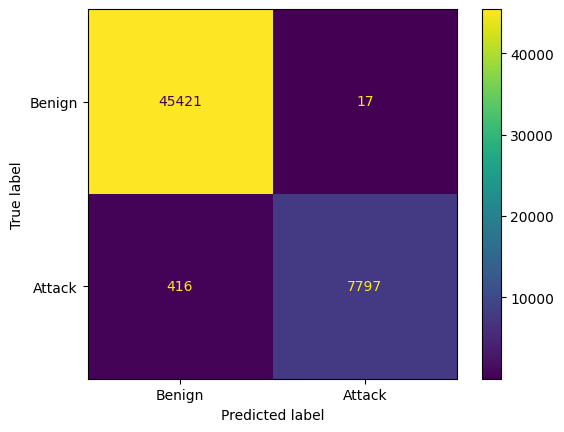

In [55]:
start_time = time.time()
train_metrics_ae_lstm = eval_ae_lstm(train_loader)
train_infer_time_ae_lstm = round((time.time() - start_time) * 1000)

Accuracy: 0.9443
Benign      Precision: 0.9364  Recall: 0.9971  F1: 0.9658  Support: 14016
Attack      Precision: 0.9856  Recall: 0.7477  F1: 0.8504  Support: 3762

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9364    0.9971    0.9658     14016
      Attack     0.9856    0.7477    0.8504      3762

    accuracy                         0.9443     17778
   macro avg     0.9610    0.8724    0.9081     17778
weighted avg     0.9468    0.9443    0.9414     17778



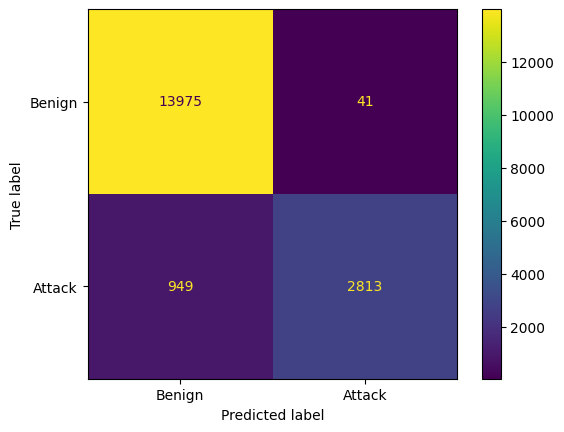

In [56]:
start_time = time.time()
val_metrics_ae_lstm = eval_ae_lstm(val_loader)
test_infer_time_ae_lstm = round((time.time() - start_time) * 1000)

# Double DQN

In [57]:
class TrafficEnv:
    def __init__(self, features, labels, seq_len, batch_size):
        if features.ndim == 2:
            T, D = features.shape
            windows = np.stack(
                [features[i : i + seq_len] for i in range(T - seq_len + 1)]
            )
            targets = labels[seq_len - 1 :]
        else:
            windows = features
            targets = labels

        self.features = windows                         
        self.labels = targets                            
        self.seq_len = seq_len
        self.feature_dim = windows.shape[2]
        self.batch_size = batch_size
        self.num_samples = windows.shape[0]
        self.num_batches = (self.num_samples + batch_size - 1) // batch_size
        self.batch_idx = 0
        self.valid_size = None
        self.current_labels = None

    def reset(self):
        self.batch_idx = 0
        return self._get_batch(0, min(self.batch_size, self.num_samples))

    def step(self, actions):
        # compute reward for the *previous* batch
        reward = np.where(actions == self.current_labels, 1.0, -1.0)
        self.batch_idx += 1

        if self.batch_idx >= self.num_batches:
            return None, reward, True

        start = self.batch_idx * self.batch_size
        end = min(start + self.batch_size, self.num_samples)
        return self._get_batch(start, end), reward, False

    def _get_batch(self, start, end):
        batch = self.features[start:end]
        labels = self.labels[start:end]
        size = end - start

        if size < self.batch_size:
            pad_size = self.batch_size - size
            pad_batch = np.zeros((pad_size, self.seq_len, self.feature_dim),
                                 dtype=self.features.dtype)
            pad_labels = np.full((pad_size,), -1, dtype=self.labels.dtype)
            batch = np.concatenate([batch, pad_batch], axis=0)
            labels = np.concatenate([labels, pad_labels], axis=0)

        self.current_labels = labels
        self.valid_size = size
        return batch

In [58]:
class DRQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim):
        super(DRQN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, action_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        q_values = self.fc(out[:, -1, :])
        return q_values, hidden

    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(1, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(1, batch_size, self.hidden_dim, device=device)
        return (h0, c0)

In [59]:
hidden_dim = 128
seq_len = 20
input_dim = 53
action_dim = 2
policy_net = DRQN(input_dim=input_dim, hidden_dim=hidden_dim, action_dim=action_dim).to(device)
state = torch.load(
    'best_drqn.pt',
    weights_only=True,
    map_location=device
)
policy_net.load_state_dict(state)
policy_net.eval()

DRQN(
  (lstm): LSTM(53, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [60]:
def eval_dqn(features_set, labels, batch_size):
    env = TrafficEnv(features_set, labels, seq_len, batch_size)
    batch = env.reset()
    hidden = policy_net.init_hidden(batch.shape[0], device)

    all_preds = []
    all_true = []

    policy_net.eval()
    with torch.no_grad():
        done = False
        while not done:
            x = torch.tensor(batch, dtype=torch.float32, device=device)
            x = x.view(batch.shape[0], seq_len, input_dim)

            qvals, hidden = policy_net(x, hidden)
            actions = qvals.argmax(dim=1).cpu().numpy()

            valid = env.valid_size
            all_preds.extend(actions[:valid].tolist())
            all_true.extend(env.current_labels[:valid].tolist())
        
            batch, _, done = env.step(actions)
    return get_classification_report(all_preds, all_true)

Accuracy: 0.9543
Benign      Precision: 0.9590  Recall: 0.9882  F1: 0.9734  Support: 45438
Attack      Precision: 0.9217  Recall: 0.7663  F1: 0.8369  Support: 8213

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9590    0.9882    0.9734     45438
      Attack     0.9217    0.7663    0.8369      8213

    accuracy                         0.9543     53651
   macro avg     0.9403    0.8773    0.9051     53651
weighted avg     0.9533    0.9543    0.9525     53651



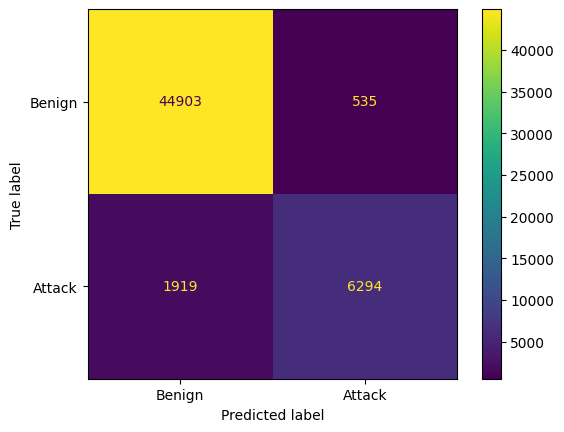

In [61]:
start_time = time.time()
train_metrics_dqn = eval_dqn(seq_train, seq_labels_train, 128)
train_infer_time_dqn = round((time.time() - start_time) * 1000)

Accuracy: 0.9248
Benign      Precision: 0.9166  Recall: 0.9952  F1: 0.9543  Support: 14016
Attack      Precision: 0.9738  Recall: 0.6624  F1: 0.7885  Support: 3762

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9166    0.9952    0.9543     14016
      Attack     0.9738    0.6624    0.7885      3762

    accuracy                         0.9248     17778
   macro avg     0.9452    0.8288    0.8714     17778
weighted avg     0.9287    0.9248    0.9192     17778



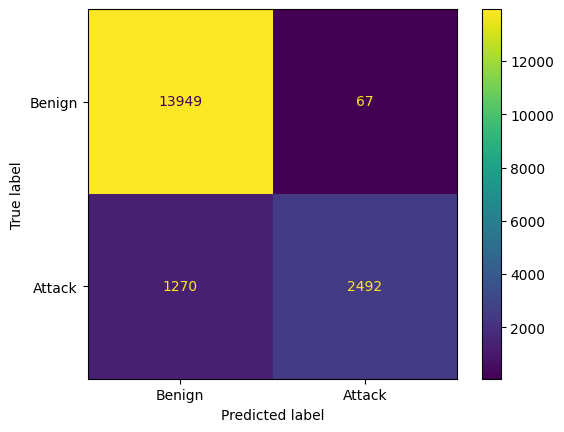

In [62]:
start_time = time.time()
test_metrics_dqn = eval_dqn(seq_test, seq_labels_test, 128)
test_infer_time_dqn = round((time.time() - start_time) * 1000)

# Heuristics

In [63]:
def eval_detect_syn_ratio(sequences, labels, cls_thresh=0.2):
    threshold = 0.6
    all_preds = []
    all_labels = []

    class_names = ["Benign", "Attack"]
    
    for i, sequence in enumerate(sequences):
        seq_preds = []
        for idx, flow in sequence.iterrows():
            if flow["Total Fwd Packets"] == 0:
                seq_preds.append(0)
                continue
            syn_ratio = flow["SYN Flag Count"] / flow["Total Fwd Packets"]
            if syn_ratio > threshold:
                seq_preds.append(1)
                continue
            seq_preds.append(0)
                
        seq_label = int(np.mean(seq_preds) > cls_thresh)
        all_preds.append(seq_label)
        all_labels.append(labels[i])
        
    return get_classification_report(all_preds, all_labels)

Accuracy: 0.6737
Benign      Precision: 0.8154  Recall: 0.7945  F1: 0.8048  Support: 45438
Attack      Precision: 0.0045  Recall: 0.0051  F1: 0.0048  Support: 8213

Classification Report:
              precision    recall  f1-score   support

      Benign     0.8154    0.7945    0.8048     45438
      Attack     0.0045    0.0051    0.0048      8213

    accuracy                         0.6737     53651
   macro avg     0.4100    0.3998    0.4048     53651
weighted avg     0.6913    0.6737    0.6824     53651



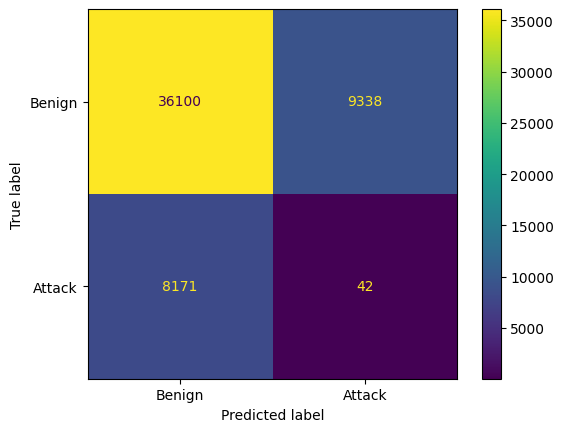

In [64]:
start_time = time.time()
train_metrics_syn_ratio = eval_detect_syn_ratio(seq_df_train, seq_df_labels_train)
train_infer_time_syn_ratio = round((time.time() - start_time) * 1000)

Accuracy: 0.5797
Benign      Precision: 0.7326  Recall: 0.7353  F1: 0.7339  Support: 14016
Attack      Precision: 0.0000  Recall: 0.0000  F1: 0.0000  Support: 3762

Classification Report:
              precision    recall  f1-score   support

      Benign     0.7326    0.7353    0.7339     14016
      Attack     0.0000    0.0000    0.0000      3762

    accuracy                         0.5797     17778
   macro avg     0.3663    0.3677    0.3670     17778
weighted avg     0.5776    0.5797    0.5786     17778



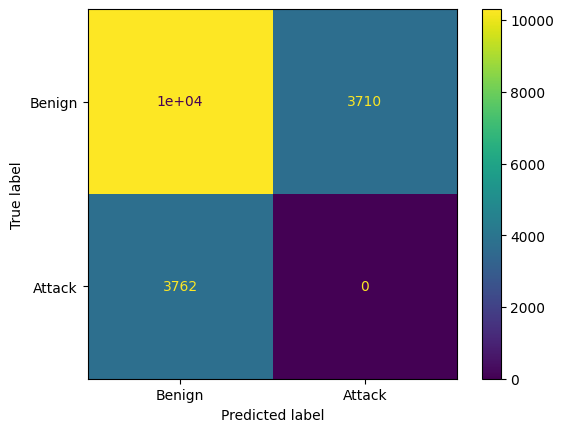

In [65]:
start_time = time.time()
test_metrics_syn_ratio = eval_detect_syn_ratio(seq_df_test, seq_df_labels_test)
test_infer_time_syn_ratio = round((time.time() - start_time) * 1000)

In [66]:
def eval_detect_iat_regularity(sequences, labels, cls_thresh=0.2):
    cv_threshold = 0.1
    all_preds = []
    all_labels = []

    class_names = ["Benign", "Attack"]
    
    for i, sequence in enumerate(sequences):
        seq_preds = []
        for idx, flow in sequence.iterrows():
            if flow["Flow IAT Mean"] == 0:
                if flow["Flow IAT Std"] == 0:
                    seq_preds.append(1)
                    continue
            iat_cv = flow["Flow IAT Std"] / flow["Flow IAT Mean"]
            if iat_cv < cv_threshold:
                seq_preds.append(1)
                continue
            seq_preds.append(0)
        seq_label = int(np.mean(seq_preds) > cls_thresh)
        all_preds.append(seq_label)
        all_labels.append(labels[i])
    
    return get_classification_report(all_preds, all_labels)

Accuracy: 0.1519
Benign      Precision: 0.4977  Recall: 0.1468  F1: 0.2268  Support: 45438
Attack      Precision: 0.0367  Recall: 0.1800  F1: 0.0610  Support: 8213

Classification Report:
              precision    recall  f1-score   support

      Benign     0.4977    0.1468    0.2268     45438
      Attack     0.0367    0.1800    0.0610      8213

    accuracy                         0.1519     53651
   macro avg     0.2672    0.1634    0.1439     53651
weighted avg     0.4271    0.1519    0.2014     53651



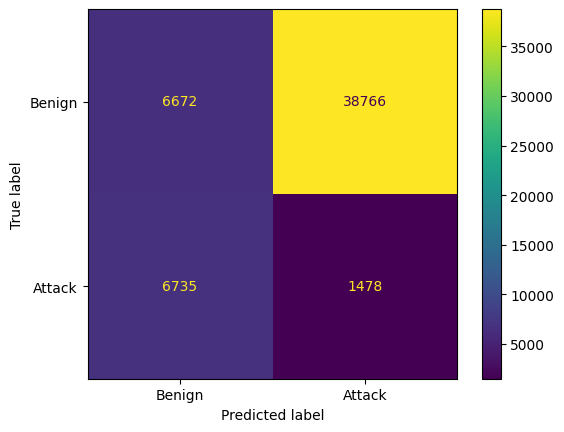

In [67]:
start_time = time.time()
train_metrics_iat_regularity = eval_detect_iat_regularity(seq_df_train, seq_df_labels_train)
train_infer_time_iat_regularity = round((time.time() - start_time) * 1000)

Accuracy: 0.3814
Benign      Precision: 0.6747  Recall: 0.4159  F1: 0.5146  Support: 14016
Attack      Precision: 0.1041  Recall: 0.2528  F1: 0.1474  Support: 3762

Classification Report:
              precision    recall  f1-score   support

      Benign     0.6747    0.4159    0.5146     14016
      Attack     0.1041    0.2528    0.1474      3762

    accuracy                         0.3814     17778
   macro avg     0.3894    0.3343    0.3310     17778
weighted avg     0.5539    0.3814    0.4369     17778



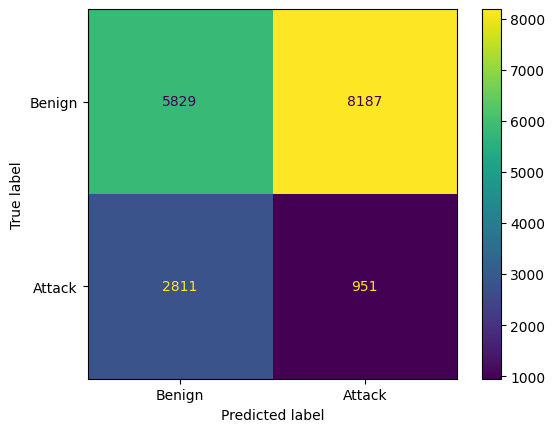

In [68]:
start_time = time.time()
test_metrics_iat_regularity = eval_detect_iat_regularity(seq_df_test, seq_df_labels_test)
test_infer_time_iat_regularity = round((time.time() - start_time) * 1000)

In [69]:
def eval_detect_unidirectionality(sequences, labels, cls_thresh=0.2):
    threshold = 0.05
    all_preds = []
    all_labels = []

    class_names = ["Benign", "Attack"]
    
    for i, sequence in enumerate(sequences):
        seq_preds = []
        for idx, flow in sequence.iterrows():
            if flow["Flow IAT Mean"] == 0:
                seq_preds.append(0)
                continue
            if flow["Down/Up Ratio"] < threshold:
                seq_preds.append(1)
                continue
            seq_preds.append(0)
        seq_label = int(np.mean(seq_preds) > cls_thresh)
        all_preds.append(seq_label)
        all_labels.append(labels[i])
    
    return get_classification_report(all_preds, all_labels)

Accuracy: 0.9418
Benign      Precision: 0.9906  Recall: 0.9402  F1: 0.9647  Support: 45438
Attack      Precision: 0.7418  Recall: 0.9507  F1: 0.8333  Support: 8213

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9906    0.9402    0.9647     45438
      Attack     0.7418    0.9507    0.8333      8213

    accuracy                         0.9418     53651
   macro avg     0.8662    0.9454    0.8990     53651
weighted avg     0.9525    0.9418    0.9446     53651



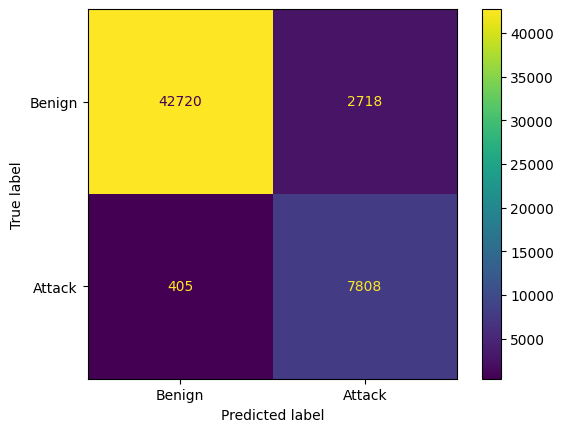

In [70]:
start_time = time.time()
train_metrics_unidirectionality = eval_detect_unidirectionality(seq_df_train, seq_df_labels_train)
train_infer_time_unidirectionality = round((time.time() - start_time) * 1000)

Accuracy: 0.8864
Benign      Precision: 0.9373  Recall: 0.9172  F1: 0.9272  Support: 14016
Attack      Precision: 0.7144  Recall: 0.7714  F1: 0.7418  Support: 3762

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9373    0.9172    0.9272     14016
      Attack     0.7144    0.7714    0.7418      3762

    accuracy                         0.8864     17778
   macro avg     0.8259    0.8443    0.8345     17778
weighted avg     0.8901    0.8864    0.8879     17778



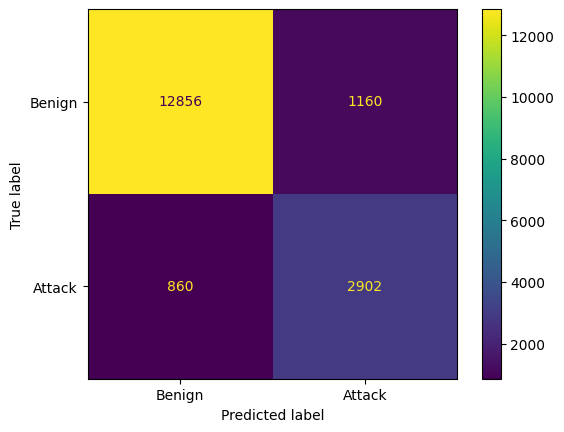

In [71]:
start_time = time.time()
test_metrics_unidirectionality = eval_detect_unidirectionality(seq_df_test, seq_df_labels_test)
test_infer_time_unidirectionality = round((time.time() - start_time) * 1000)

# Comparison Evaluation. AE + LSTM

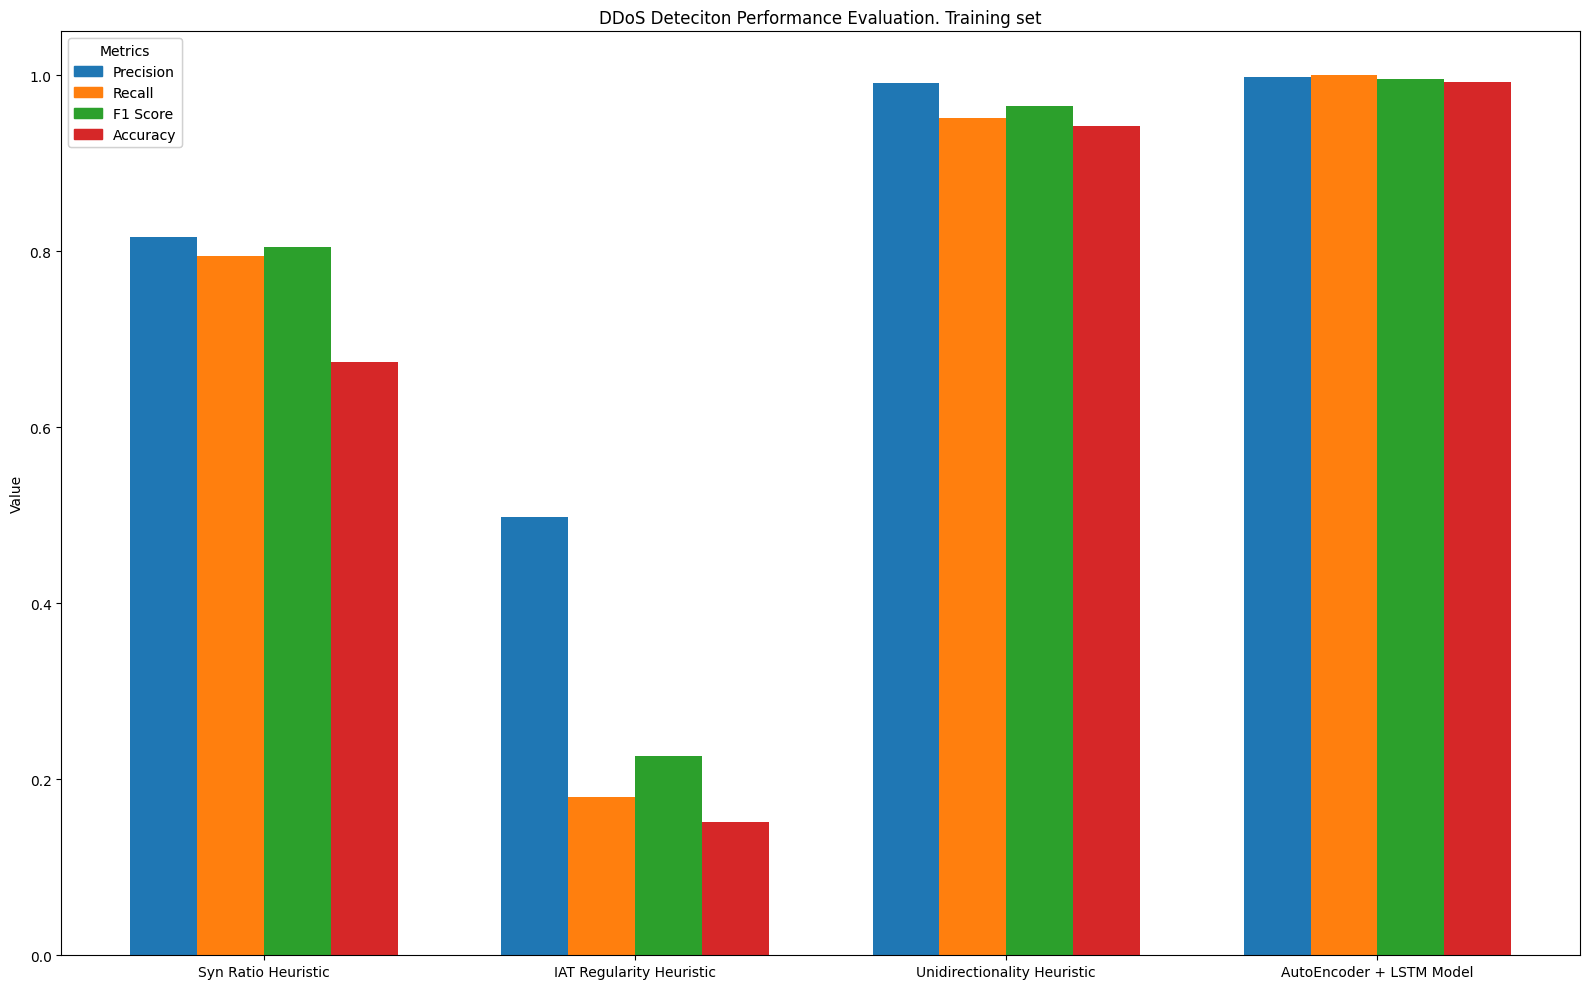

In [72]:
groups = [
    "Syn Ratio Heuristic",
    "IAT Regularity Heuristic",
    "Unidirectionality Heuristic",
    "AutoEncoder + LSTM Model",
]

metrics = [
    "Precision",
    "Recall",
    "F1 Score",
    "Accuracy",
]

metrics_vals_train = [
    train_metrics_syn_ratio,
    train_metrics_iat_regularity,
    train_metrics_unidirectionality,
    train_metrics_ae_lstm,
]

metrics_vals_test = [
    test_metrics_syn_ratio,
    test_metrics_iat_regularity,
    test_metrics_unidirectionality,
    val_metrics_ae_lstm,
]

draw_comparison_graph(metrics, metrics_vals_train, groups, 'DDoS Deteciton Performance Evaluation. Training set')

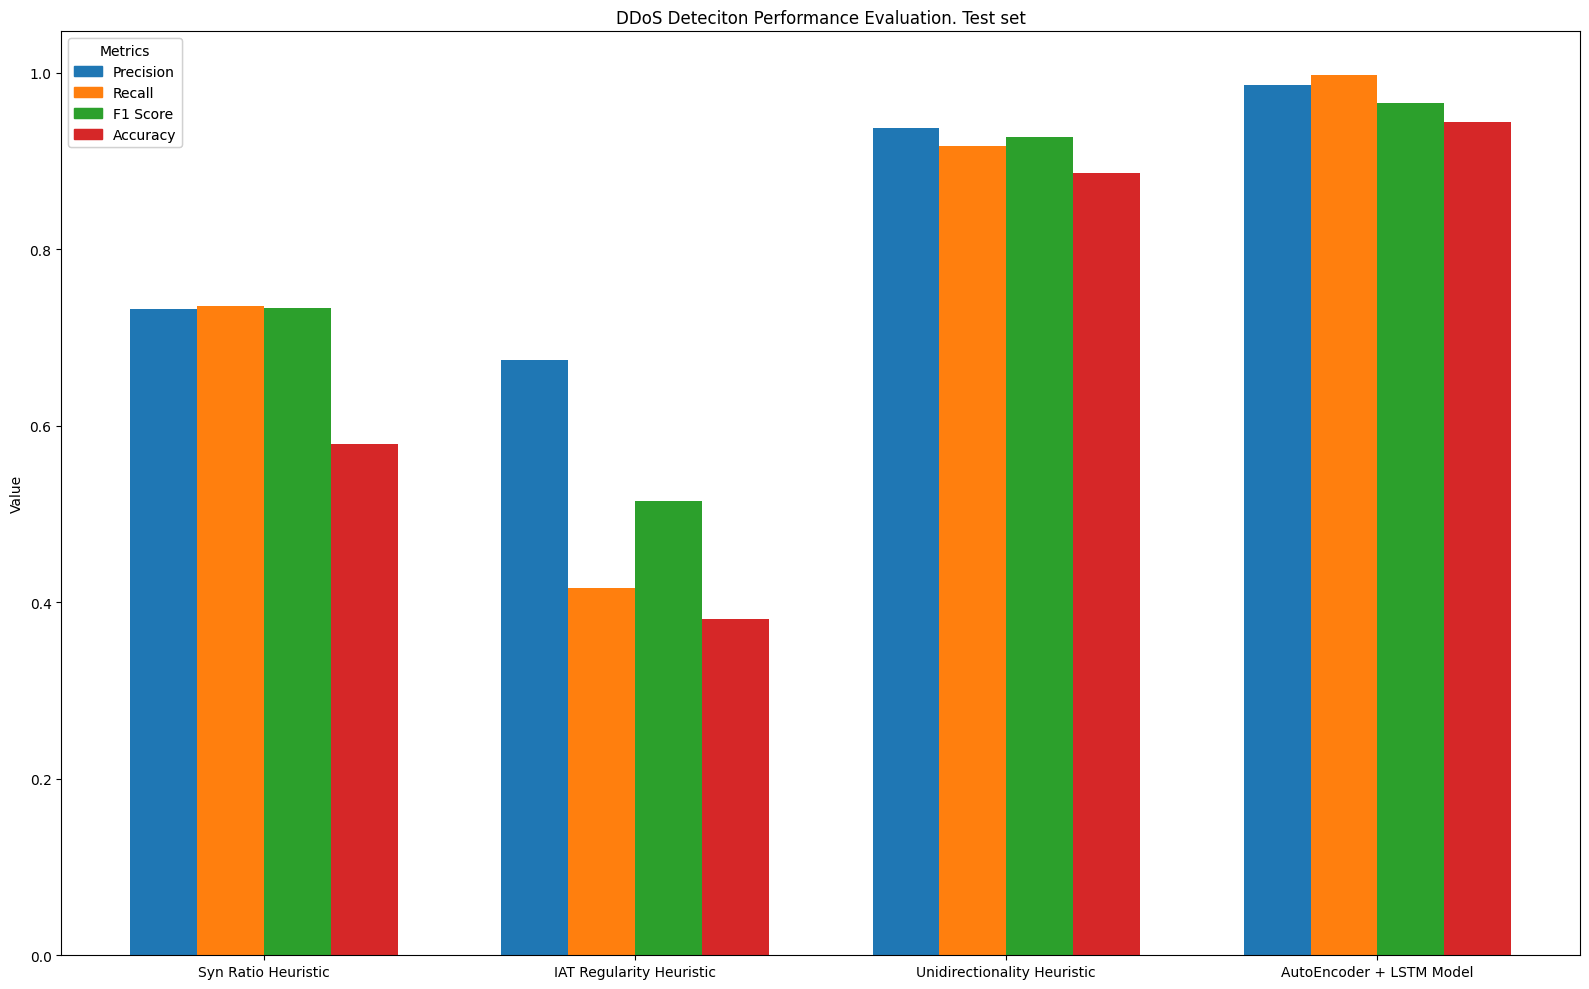

In [73]:
draw_comparison_graph(metrics, metrics_vals_test, groups, 'DDoS Deteciton Performance Evaluation. Test set')

In [111]:
infer_times_train = [
    train_infer_time_ae_lstm,
    train_infer_time_syn_ratio,
    train_infer_time_iat_regularity,
    train_infer_time_unidirectionality,
]

infer_times_test = [
    test_infer_time_ae_lstm,
    test_infer_time_syn_ratio,
    test_infer_time_iat_regularity,
    test_infer_time_unidirectionality,
]

labels = [
    "AutoEncoder + LSTM Model",
    "Syn Ratio Heuristic",
    "IAT Regularity Heuristic",
    "Unidirectionality Heuristic",
]

In [112]:
infer_times_train_per_seq = [
    infer_time / len(seq_train) for infer_time in infer_times_train
]

infer_times_test_per_seq = [
    infer_time / len(seq_test) for infer_time in infer_times_test
]

In [116]:
infer_times_test_per_seq[0]

0.027730903363707954

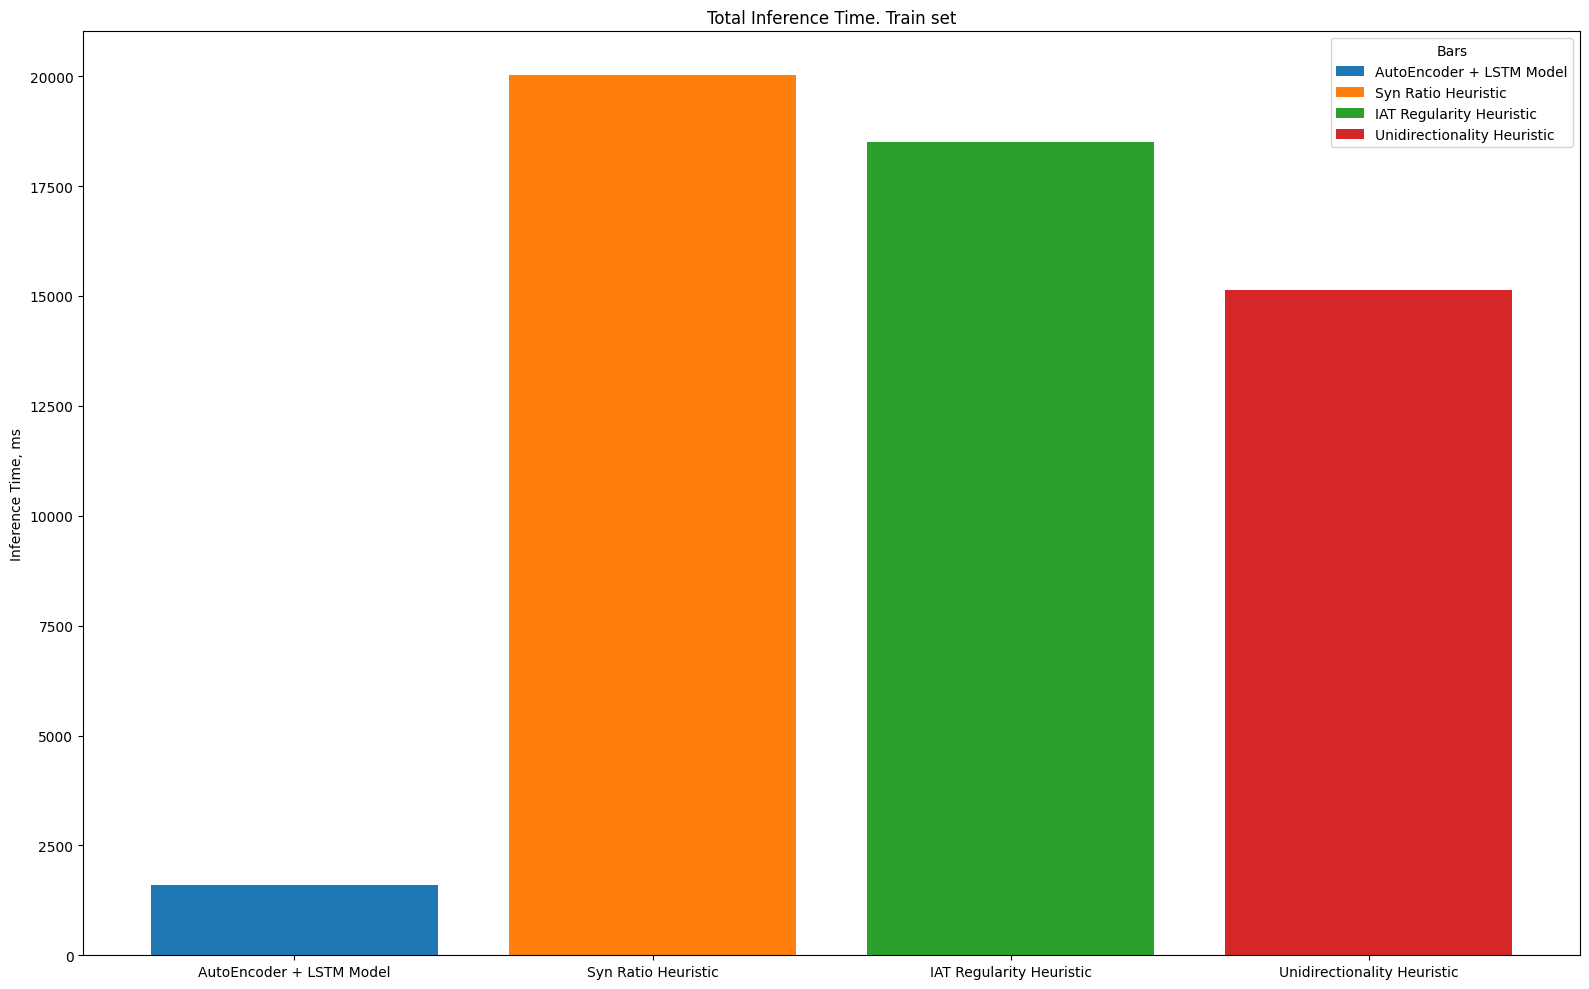

In [76]:
plot_bar_chart(infer_times_train, labels, "Total Inference Time. Train set", "Inference Time, ms")

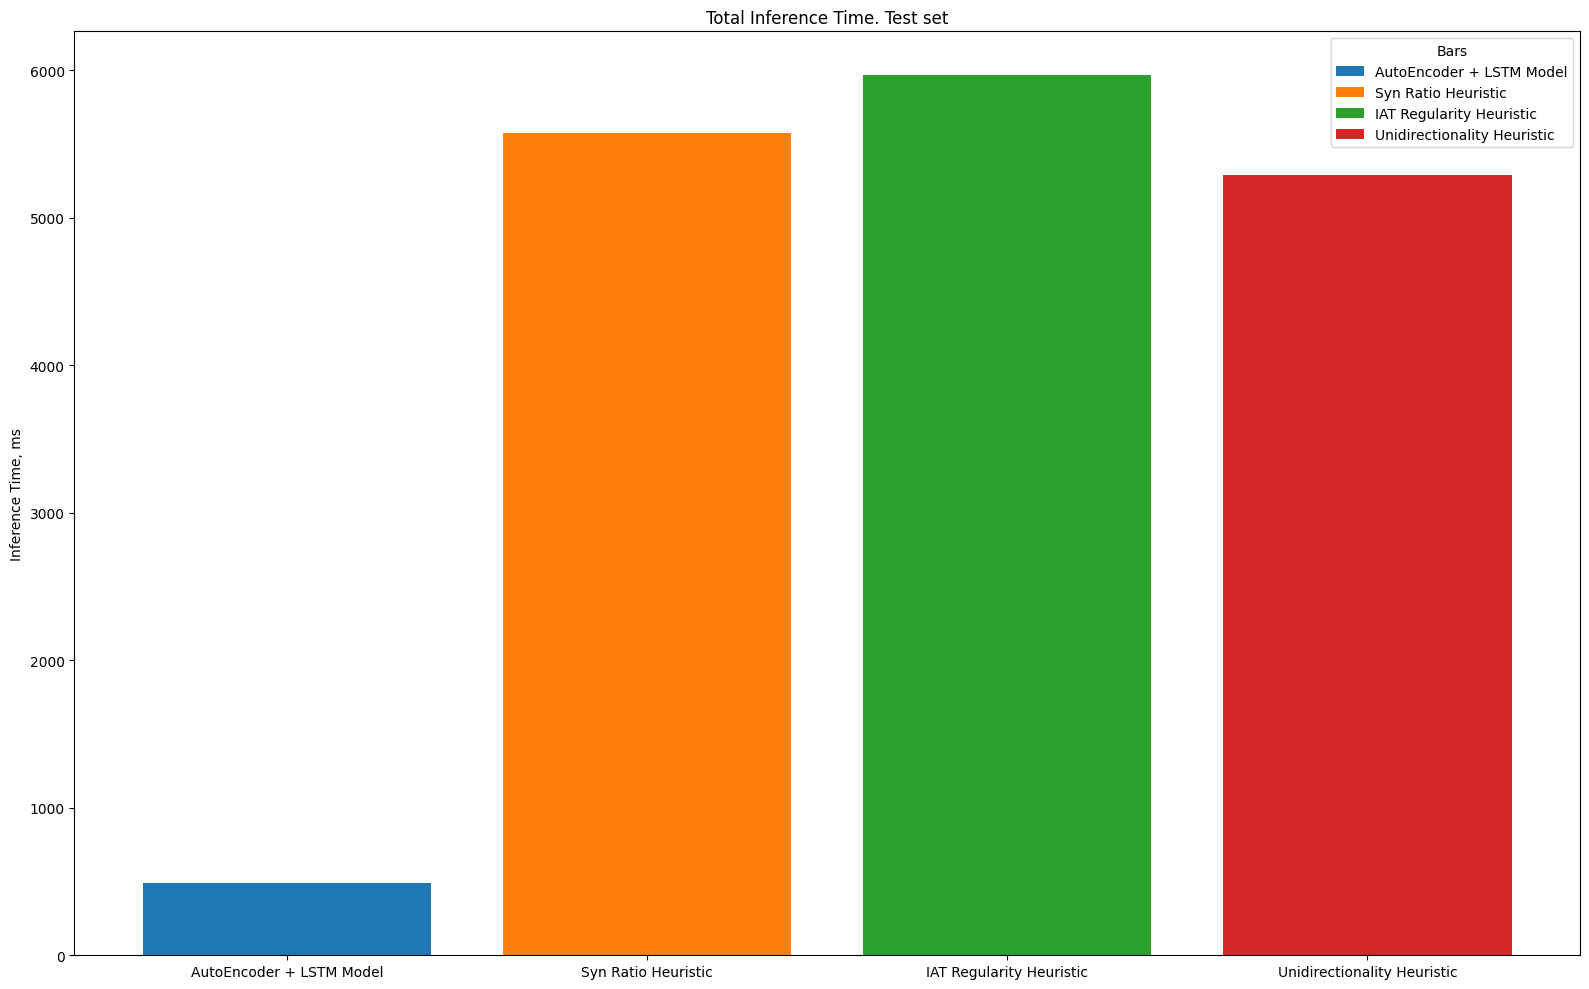

In [77]:
plot_bar_chart(infer_times_test, labels, "Total Inference Time. Test set", "Inference Time, ms")

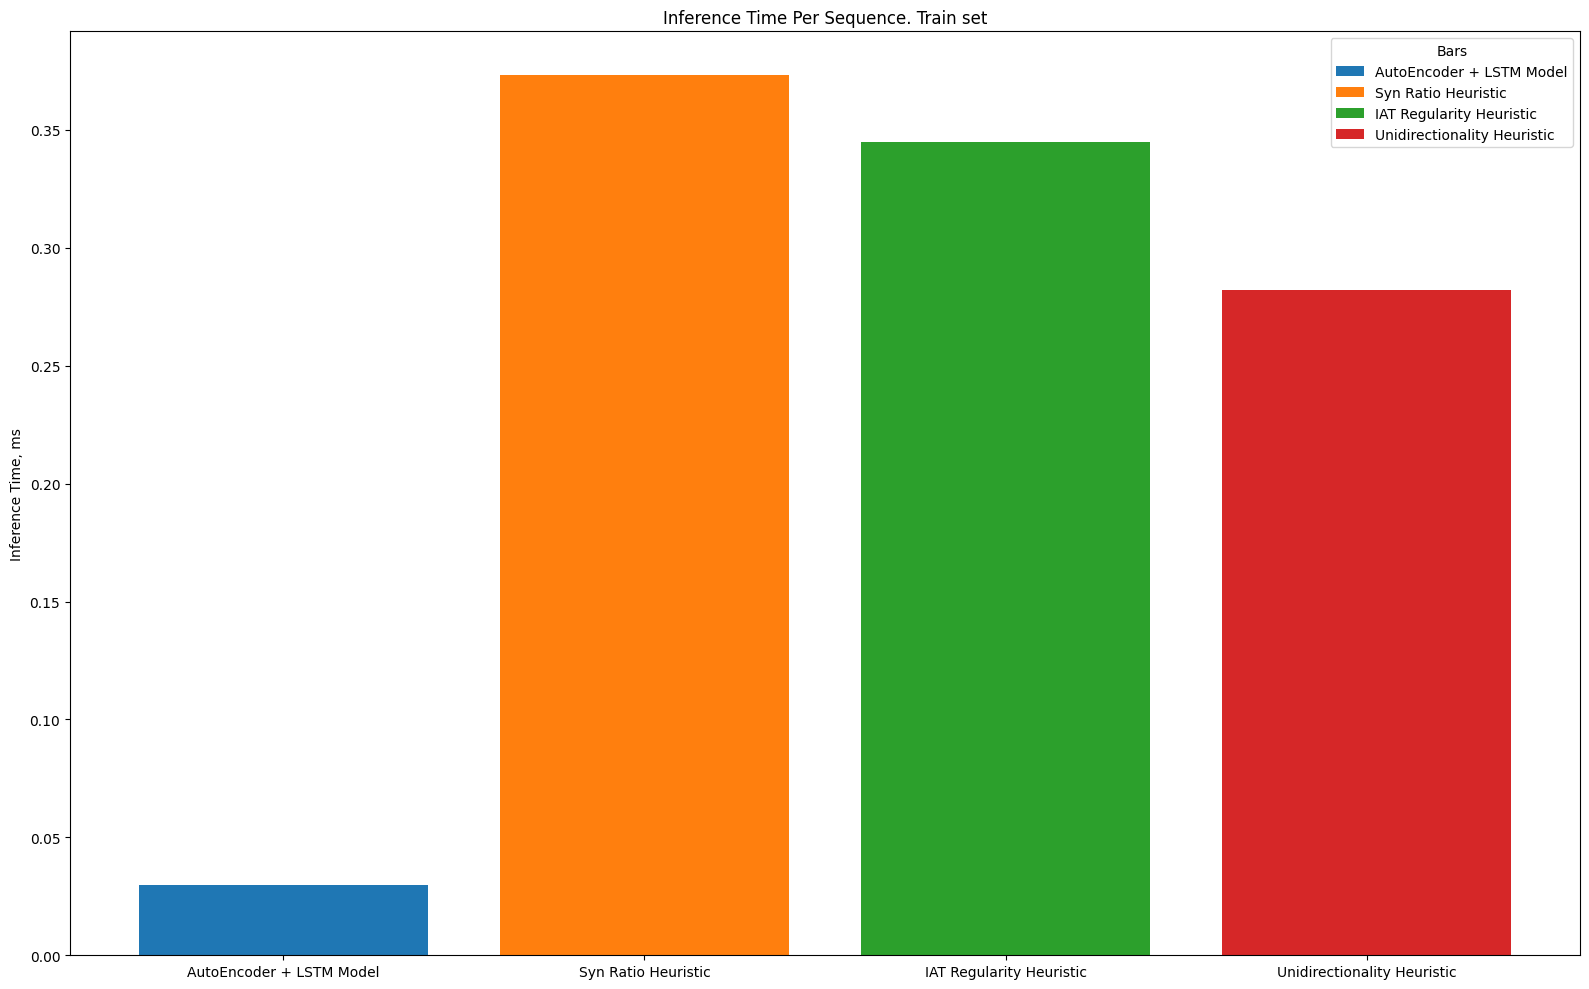

In [78]:
plot_bar_chart(infer_times_train_per_seq, labels, "Inference Time Per Sequence. Train set", "Inference Time, ms")

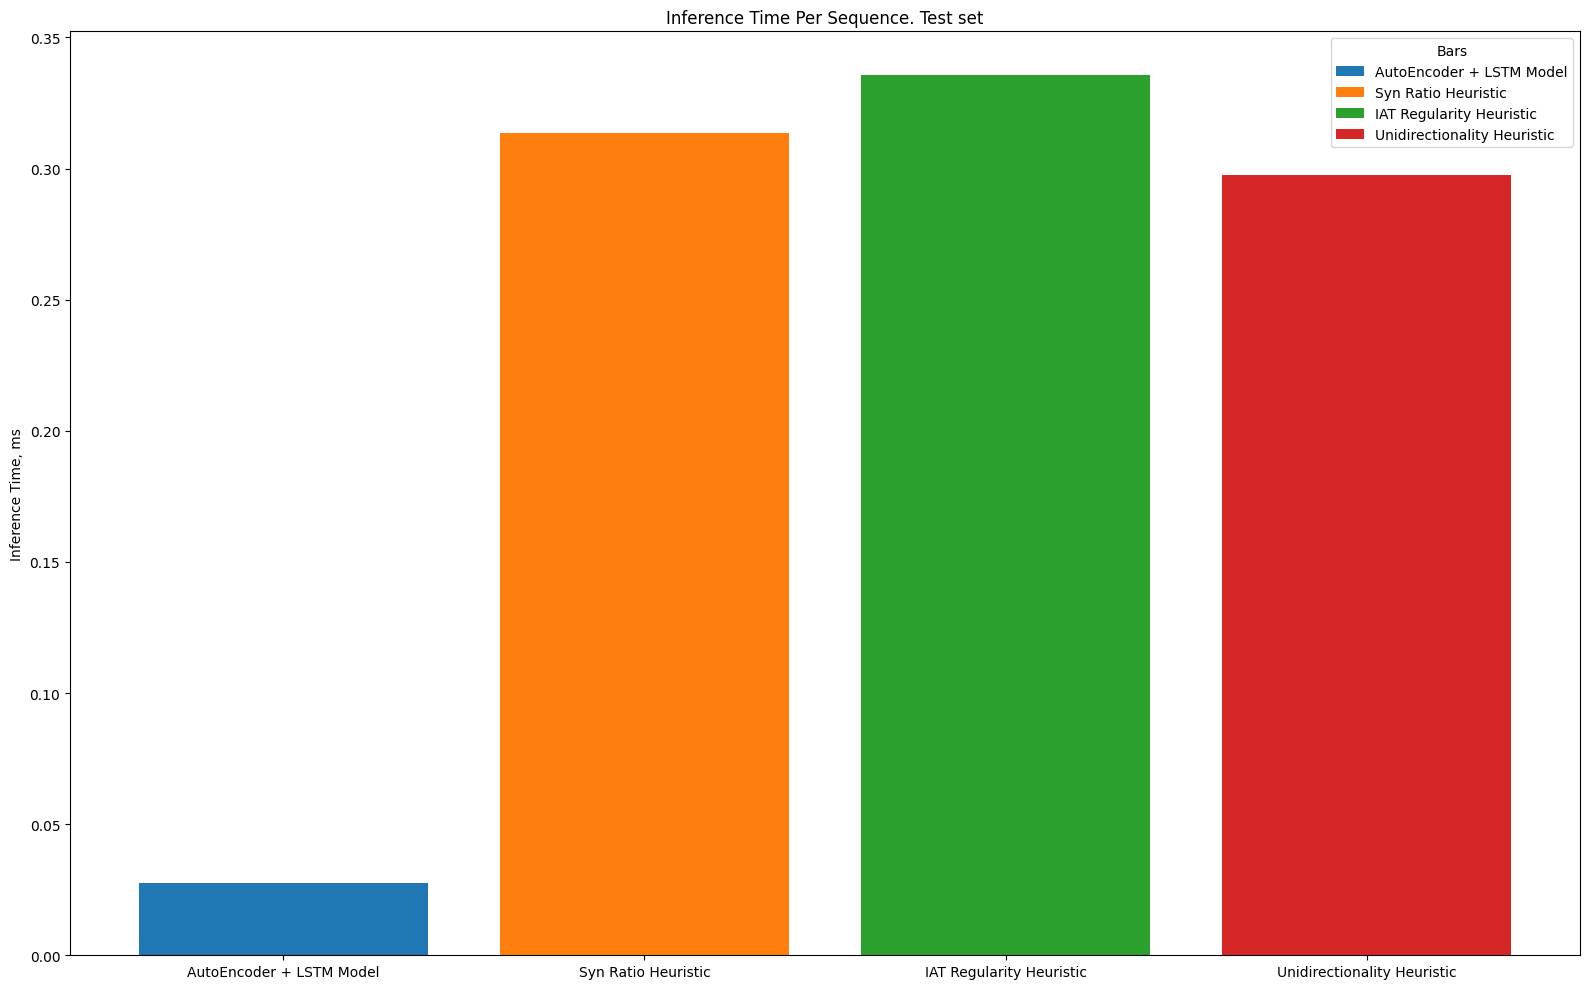

In [79]:
plot_bar_chart(infer_times_test_per_seq, labels, "Inference Time Per Sequence. Test set", "Inference Time, ms")

# Comparison Evaluation. Double DQN

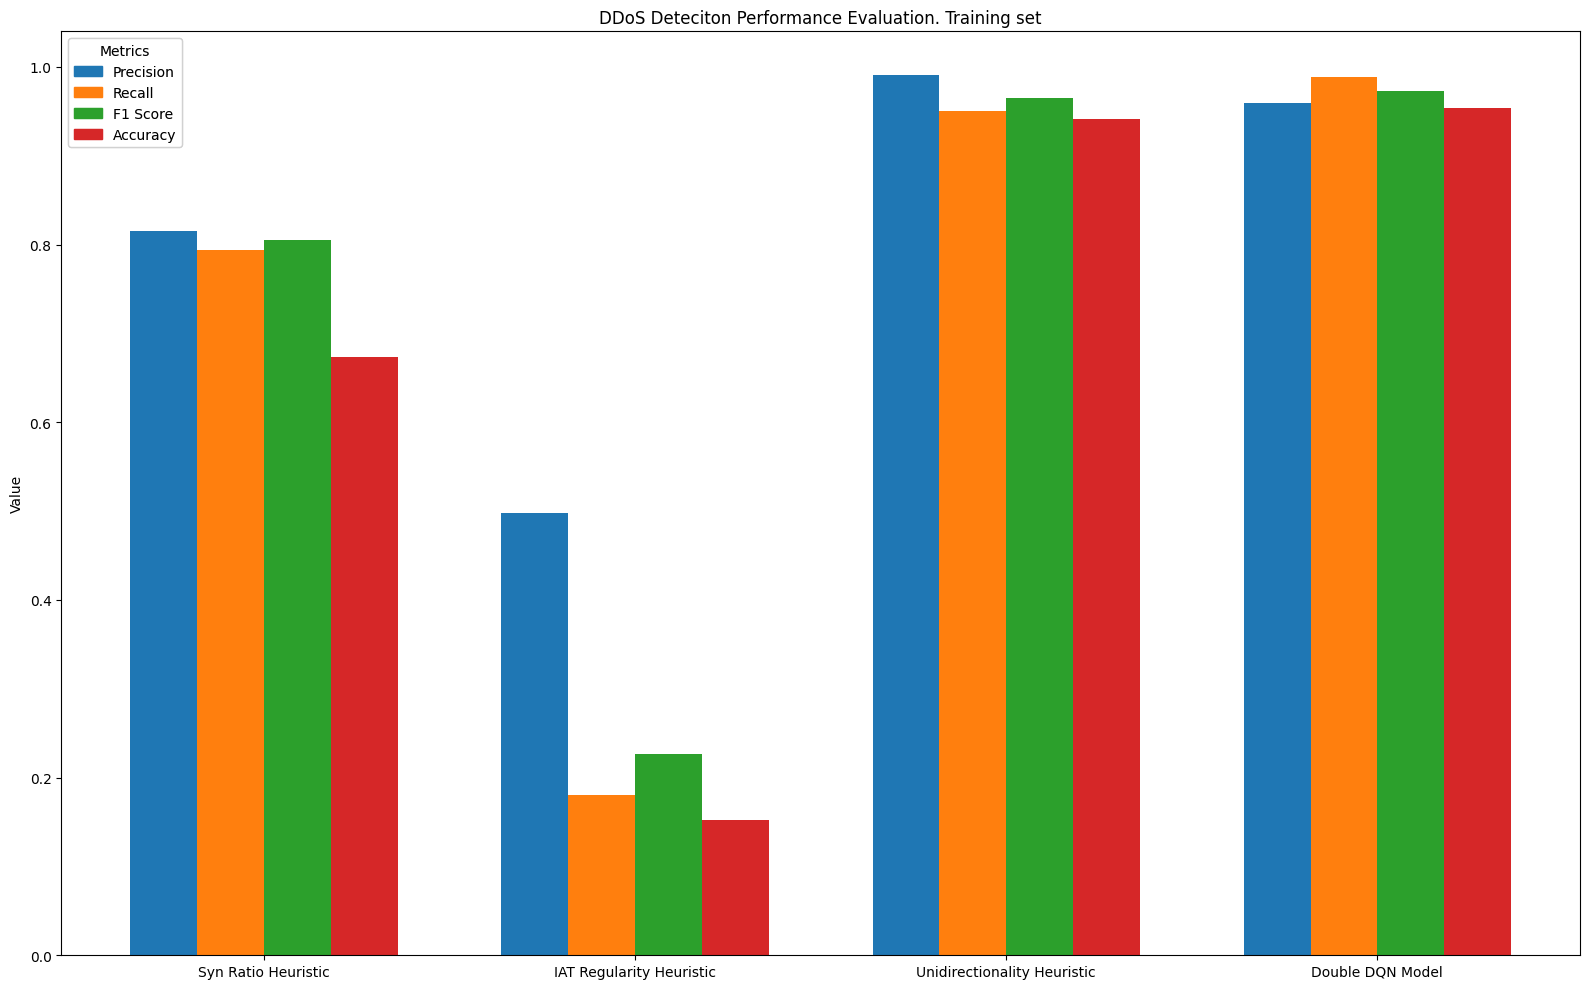

In [80]:
groups = [
    "Syn Ratio Heuristic",
    "IAT Regularity Heuristic",
    "Unidirectionality Heuristic",
    "Double DQN Model",
]

metrics = [
    "Precision",
    "Recall",
    "F1 Score",
    "Accuracy",
]

metrics_vals_train = [
    train_metrics_syn_ratio,
    train_metrics_iat_regularity,
    train_metrics_unidirectionality,
    train_metrics_dqn,
]

metrics_vals_test = [
    test_metrics_syn_ratio,
    test_metrics_iat_regularity,
    test_metrics_unidirectionality,
    test_metrics_dqn,
]

draw_comparison_graph(metrics, metrics_vals_train, groups, 'DDoS Deteciton Performance Evaluation. Training set')

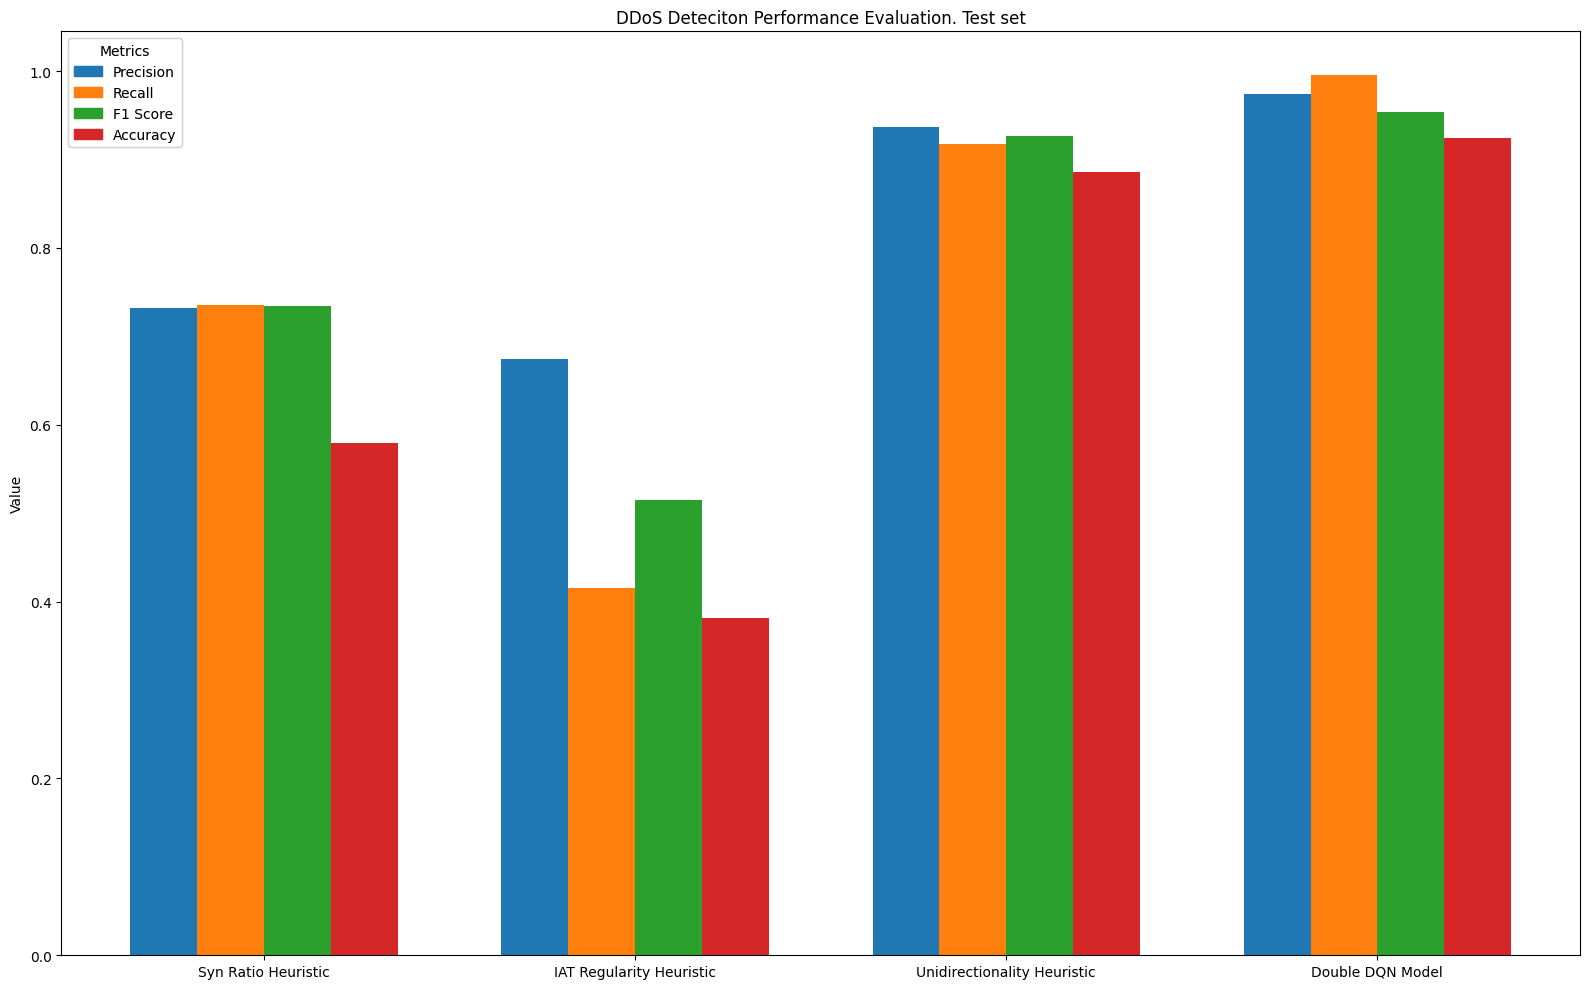

In [81]:
draw_comparison_graph(metrics, metrics_vals_test, groups, 'DDoS Deteciton Performance Evaluation. Test set')

In [82]:
infer_times_train = [
    train_infer_time_dqn,
    train_infer_time_syn_ratio,
    train_infer_time_iat_regularity,
    train_infer_time_unidirectionality,
]

infer_times_test = [
    test_infer_time_dqn,
    test_infer_time_syn_ratio,
    test_infer_time_iat_regularity,
    test_infer_time_unidirectionality,
]

labels = [
    "Double DQN",
    "Syn Ratio Heuristic",
    "IAT Regularity Heuristic",
    "Unidirectionality Heuristic",
]

In [107]:
test_infer_time_dqn

193

In [108]:
infer_times_test_per_seq[0]

0.010856114298571268

In [84]:
infer_times_train_per_seq = [
    infer_time / len(seq_train) for infer_time in infer_times_train
]

infer_times_test_per_seq = [
    infer_time / len(seq_test) for infer_time in infer_times_test
]

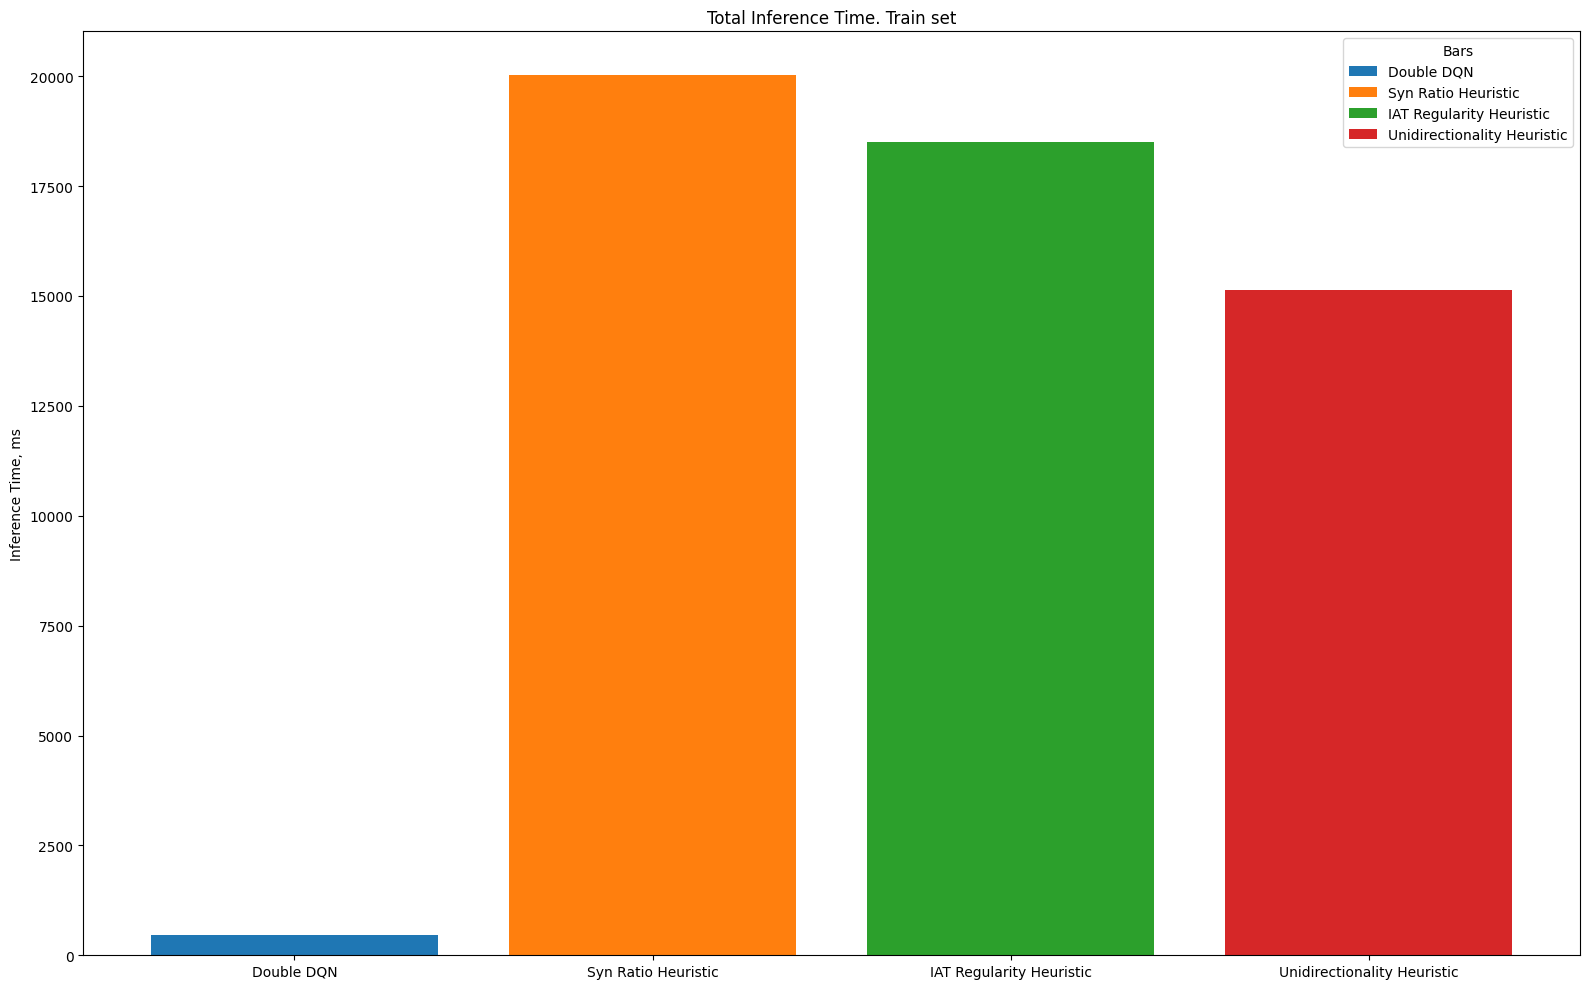

In [85]:
plot_bar_chart(infer_times_train, labels, "Total Inference Time. Train set", "Inference Time, ms")

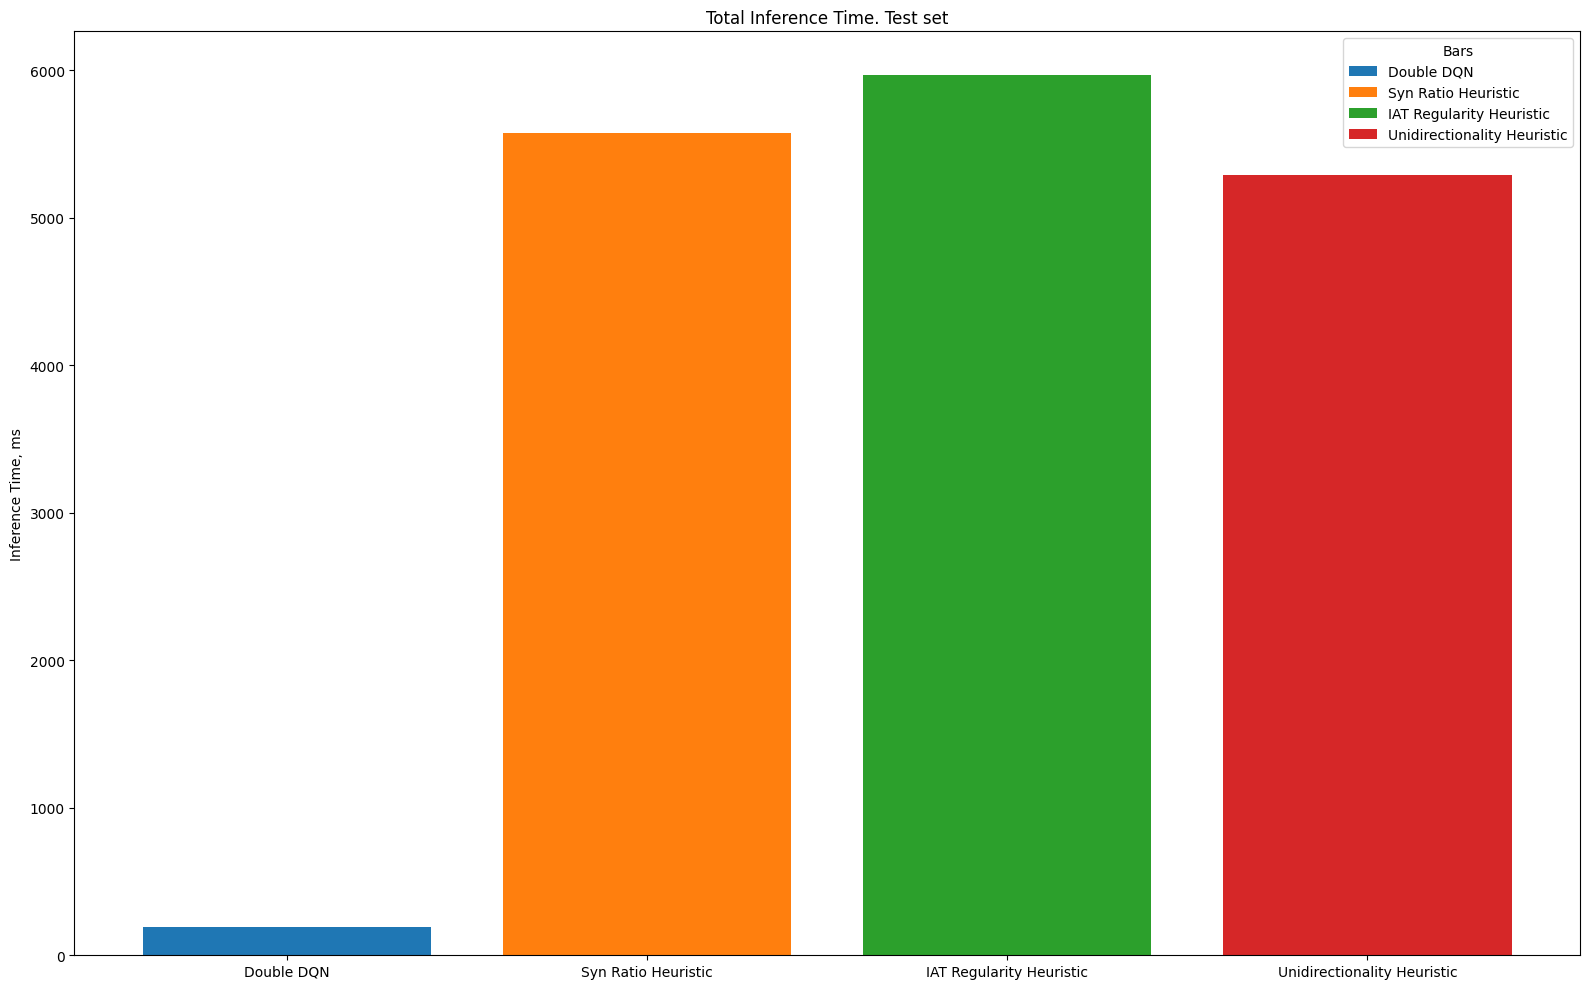

In [86]:
plot_bar_chart(infer_times_test, labels, "Total Inference Time. Test set", "Inference Time, ms")

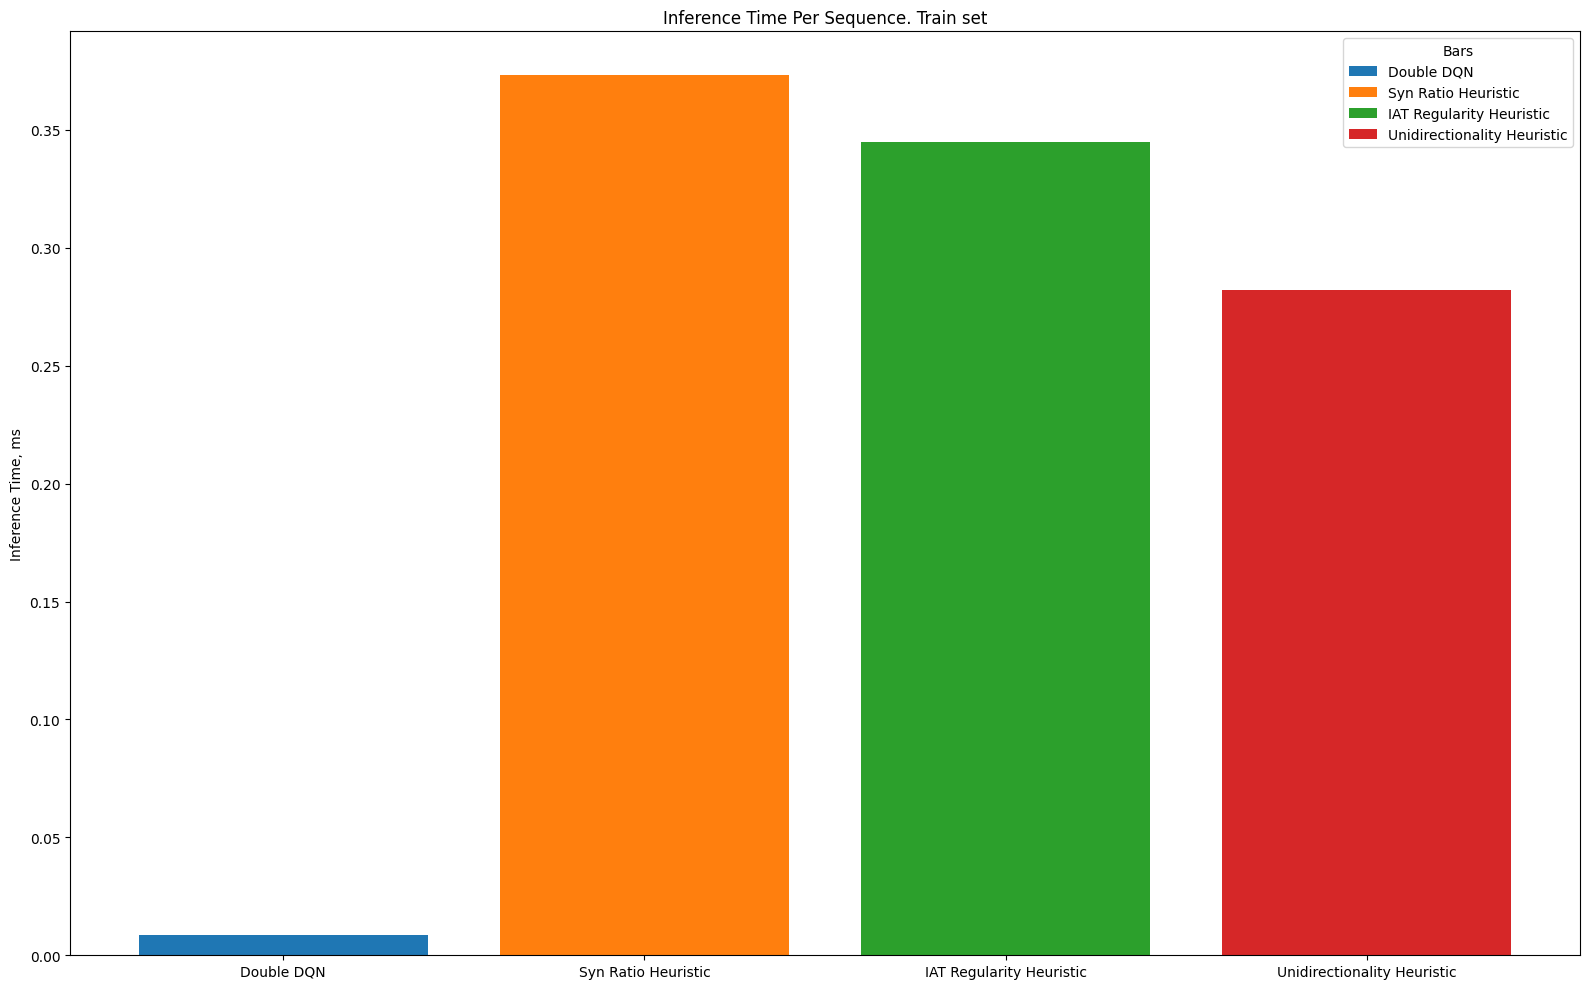

In [87]:
plot_bar_chart(infer_times_train_per_seq, labels, "Inference Time Per Sequence. Train set", "Inference Time, ms")

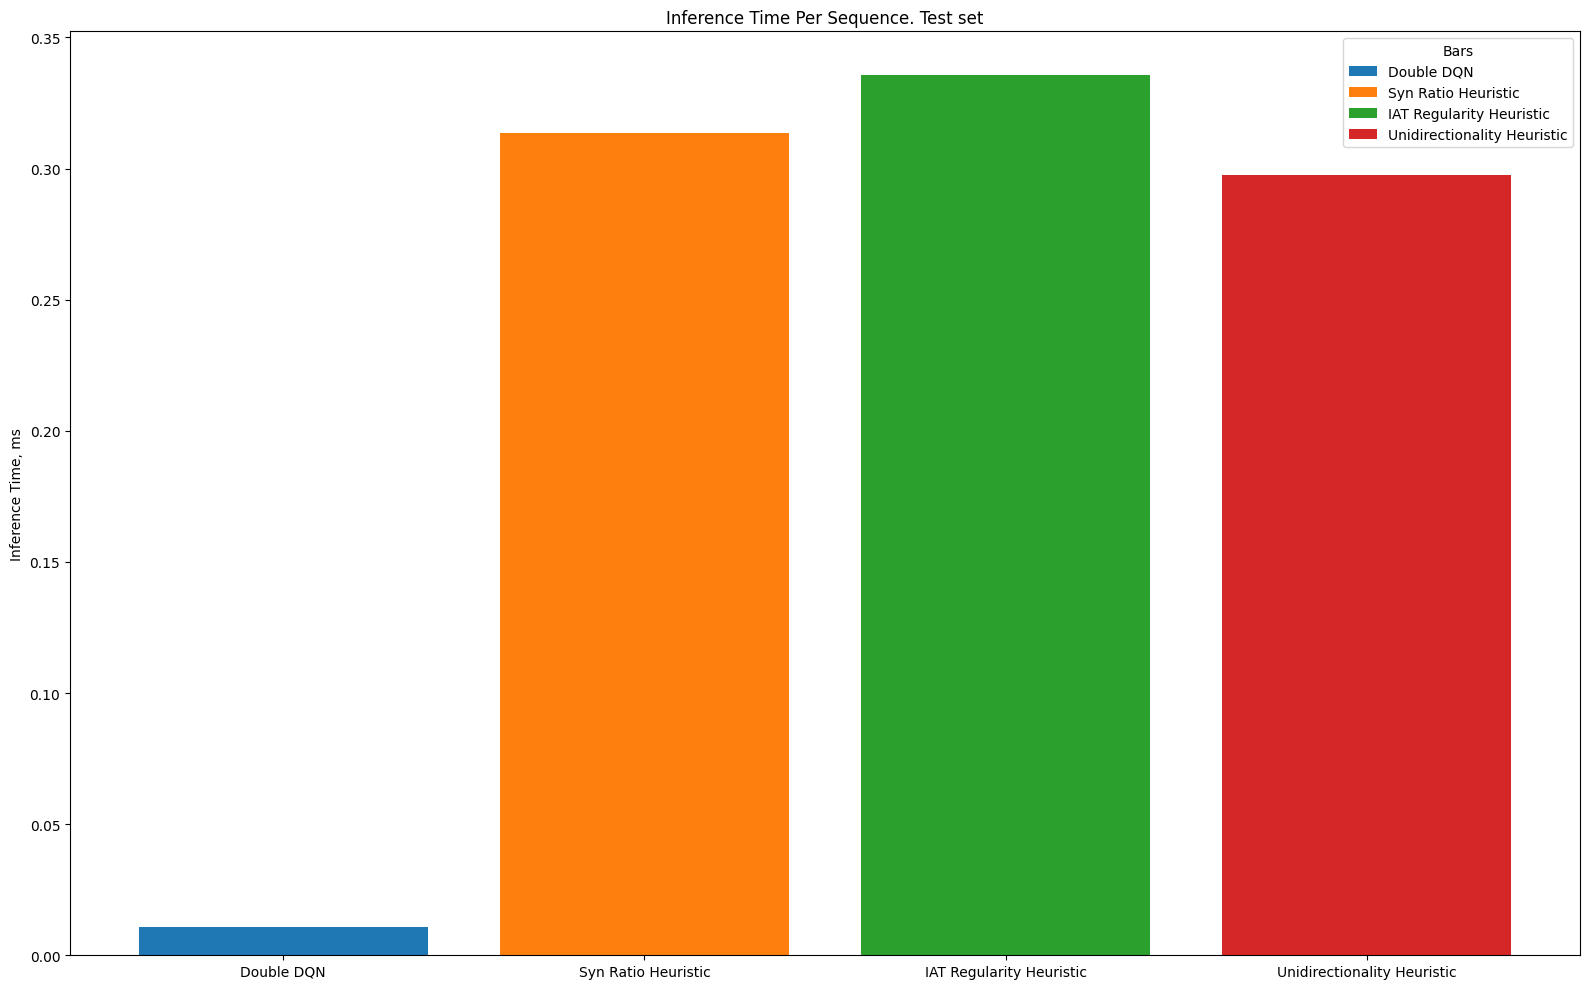

In [88]:
plot_bar_chart(infer_times_test_per_seq, labels, "Inference Time Per Sequence. Test set", "Inference Time, ms")